In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu, sobel
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import zoom, binary_dilation, binary_erosion
from skimage.measure import label, regionprops
from skimage import io, exposure, color
from skimage import measure, morphology
from skimage import exposure
from czifile import imread
from cellpose import models, plot 
from scipy.stats import skew
import cv2
import re
model = models.Cellpose(gpu=False, model_type='cyto3')

c:\Users\sj1205\AppData\Local\Programs\Python\Python312\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load

In [2]:
MIN_INCLUSION_SIZE = 10
MAX_INCLUSION_SIZE = 10000

In [3]:
def display_image(image, path, type):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{path} {type}")
    plt.show()

def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def extract_channels(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Extract green and red channels from the squeezed image (shape: [Z, C, H, W]).""" 
    return image[0], image[1]

def normalize_image(image):
    """
    Normalize the image to the range [0, 1].
    This is useful for consistent processing across different images.
    """
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def segment_cells(green_channel):
    """
    Segment whole cells in the green channel using Cellpose.
    - Normalizes image intensity.
    - Suppresses bright spots (e.g., inclusions) to better detect cell boundaries.
    - Applies Gaussian blur for smoother segmentation input.
    - Gradually increases segmentation diameter until at least one cell is detected.
    """
    green_channel = normalize_image(green_channel)
    percentile_99 = np.percentile(green_channel, 99)
    
    # Suppress very bright pixels (inclusions)
    green_channel_remove_inclusions = np.where(green_channel < percentile_99, green_channel, percentile_99)
    green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=5)

    # Normalize again after processing
    green_channel_remove_inclusions = normalize_image(green_channel_remove_inclusions)

    # Try different diameters until cells are detected
    diameter = 150
    while diameter < 500:
        masks, flows, styles, diams = model.eval(green_channel_remove_inclusions, diameter=diameter, channels=[0, 0])
        labeled_cells = label(masks)
        if np.max(labeled_cells) > 0:
            return labeled_cells
        diameter += 25

    # No cells found
    return None

def extract_inclusions(green_channel, mask, cell_number, path):
    

    applied_mask = gaussian(green_channel) * mask

    threshold = 1
    inclusions = applied_mask > threshold



    return inclusions

def generate_inclusion_image(green_channel, labeled_cells, path):
    """
    Generate a binary image with all inclusions from all cells.
    - Loops through each segmented cell.
    - Extracts inclusions from each cell region.
    - Combines all into one final binary image.
    """
    inclusion_image = np.zeros_like(green_channel)

    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 100:
            continue
        mask = labeled_cells == cell.label
        #display_image(mask, "mask", f"cell {i + 1}")
        inclusions = extract_inclusions(green_channel, mask, i +1, path)
        inclusion_image += inclusions  # adds binary inclusion mask

    return inclusion_image

def preprocess_green_channel(green_channel):
    """
    Preprocess the green fluorescence channel for better segmentation and inclusion detection.
    - Applies Gaussian blur to reduce noise.
    - Enhances contrast using sigmoid adjustment.
    - Normalizes intensities to [0, 1] for consistent processing.
    """
    confocal_img = gaussian(green_channel, sigma=2)
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = normalize_image(confocal_img)
    return confocal_img

def circularity_filter(mask: np.ndarray, threshold: float = 0.7):
    """
    Splits a binary mask into two masks based on circularity index.

    Parameters:
        mask (np.ndarray): Binary input mask (dtype=bool or 0/1).
        threshold (float): Circularity threshold to split regions.

    Returns:
        mask_high_circularity (np.ndarray): Mask with circular objects (circularity > threshold).
        mask_low_circularity (np.ndarray): Mask with less circular objects (circularity <= threshold).
    """

    labeled = label(mask)
    high_circularity_mask = np.zeros_like(mask, dtype=bool)
    low_circularity_mask = np.zeros_like(mask, dtype=bool)

    for region in regionprops(labeled):
        perimeter = region.perimeter
        area = region.area

        if perimeter == 0:
            continue  # Skip degenerate shapes

        circularity = 4 * np.pi * (area / (perimeter ** 2))

        coords = tuple(zip(*region.coords))
        if circularity > threshold:
            high_circularity_mask[coords] = True
        else:
            low_circularity_mask[coords] = True

    return high_circularity_mask, low_circularity_mask


def calculate_surface_area(labeled_image: np.ndarray) -> float:
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image)
    return sum(prop.area for prop in props)

def count_overlapping_regions(red_labeled, inclusion_mask):
    count = 0
    for region in regionprops(red_labeled):
        red_mask = np.zeros_like(inclusion_mask, dtype=bool)
        coords = tuple(zip(*region.coords))
        red_mask[coords] = True
        if np.any(red_mask & inclusion_mask):
            count += 1
    return count



In [4]:
def analysis(red, green, path):
    data = []
    green_channel = preprocess_green_channel(green)
    #display_image(green_channel, path, "Preprocessed Green Channel")

    # Segment individual cells from the green channel
    labeled_cells = segment_cells(green_channel)
    #display_image(labeled_cells, path, "Labeled Cells")
    inclusions_image = generate_inclusion_image(green_channel, labeled_cells, path)
    display_image(inclusions_image, path, "Inclusions Image")
    
    red_channel = normalize_image(red)
    red_channel = red_channel > threshold_otsu(red_channel)
    red_channel = remove_small_objects(red_channel, min_size=20)
    
    display_image(red_channel, path, "Red Channel")

    #green_channel = preprocess_green_channel(green)
    #labeled_cells = segment_cells(green_channel)
    #for i, cell in enumerate(regionprops(labeled_cells)):
    #    if cell.area < 100:  # Skip tiny regions likely to be noise
    #        continue
#
    #    # Create a mask for the current cell
    #    mask = labeled_cells == cell.label
#
    #    # Detect inclusions within the cell mask in the green channel
    #    inclusions = extract_inclusions(green_channel, mask, i+1, path)
    #    inclusions_labeled = label(inclusions)
#
    #    #find red_channel within this cell
    #    red_channel_cell = red_channel * mask
    #    red_channel_single, red_channel_clustered = circularity_filter(red_channel_cell, threshold=0.8)
#
    #    # Count the number of inclusions
    #    num_inclusions = len(regionprops(inclusions_labeled))
    #    # average size of the inclusions
    #    inclusion_size_average = np.mean([region.area for region in regionprops(inclusions_labeled)]) if num_inclusions > 0 else 0
    #    inclusion_regions = regionprops(inclusions_labeled)
    #    # if there is an overlap between the red and inclusions find the number of those occurences
    #    num_swiss_cheese_inclusions = 0
    #    for region in inclusion_regions:
    #        inclusion_mask = np.zeros_like(inclusions, dtype=bool)
    #        coords = tuple(zip(*region.coords))
    #        inclusion_mask[coords] = True
    #        if np.any(red_channel_cell & inclusion_mask):
    #            num_swiss_cheese_inclusions += 1
#
    #    num_non_swiss_cheese_inclusions = num_inclusions - num_swiss_cheese_inclusions
#
    #    # find if there is an overlap between red and the inclusions
#
#
#
    #    overlap_area = red_channel_cell * inclusions
#
    #    red_single_labeled = label(red_channel_single)
    #    red_clustered_labeled = label(red_channel_clustered)
#
#
    #    num_overlapping_red_single = count_overlapping_regions(red_single_labeled, inclusions)
    #    num_overlapping_red_clustered = count_overlapping_regions(red_clustered_labeled, inclusions)
#
#
    #    data.append({
    #        'Filename': path,
    #        'Cell Number': i + 1,
    #        'Number of Inclusions': num_inclusions,
    #        'Average Inclusion Size': inclusion_size_average,
    #        'Number of Swiss Cheese Inclusions': num_swiss_cheese_inclusions,
    #        'Number of Non-Swiss Cheese Inclusions': num_non_swiss_cheese_inclusions,
    #        'Number of Lipid Droplets': len(regionprops(label(red_channel_cell))),
    #        'Surface area of Green': calculate_surface_area(inclusions_labeled),
    #        'Surface area of Red': calculate_surface_area(label(red_channel_cell)),
    #        'Surface area of overlap': calculate_surface_area(label(overlap_area)),
    #        'Number of Overlapping Red Single': num_overlapping_red_single,
    #        'Number of Overlapping Red Clustered': num_overlapping_red_clustered,
    #    })
#
    #df_cell_summary = pd.DataFrame(data)
#
    #return df_cell_summary
       


       

       

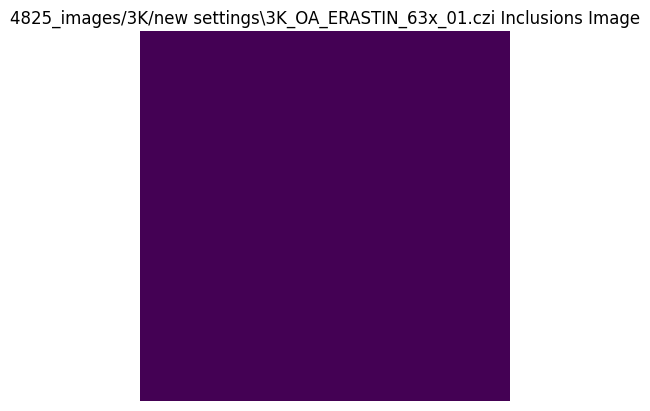

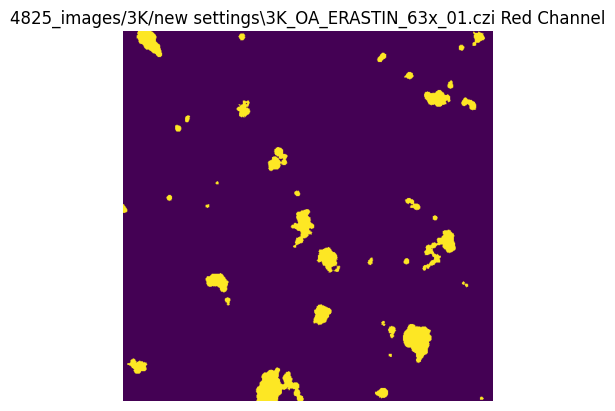

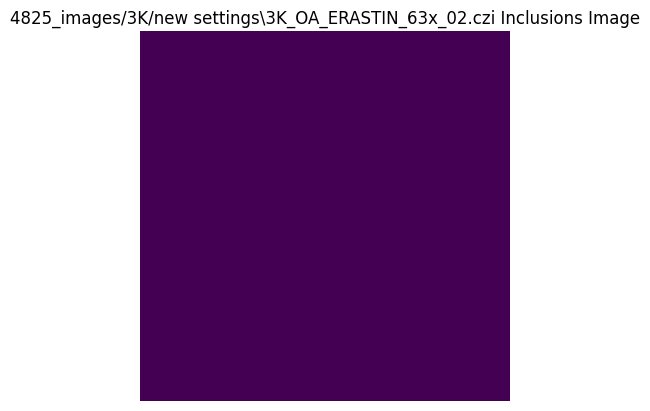

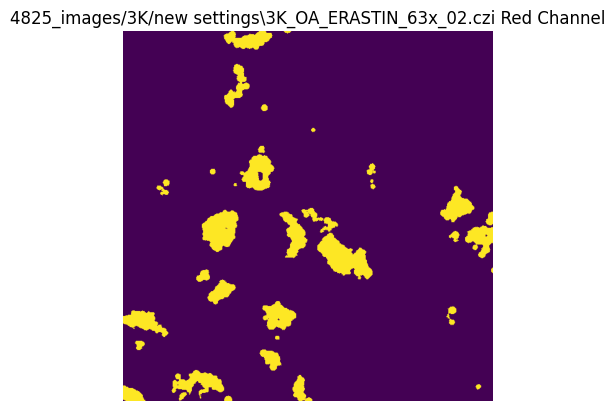

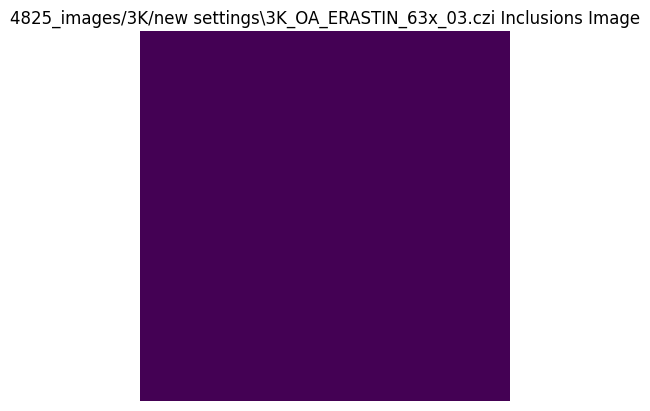

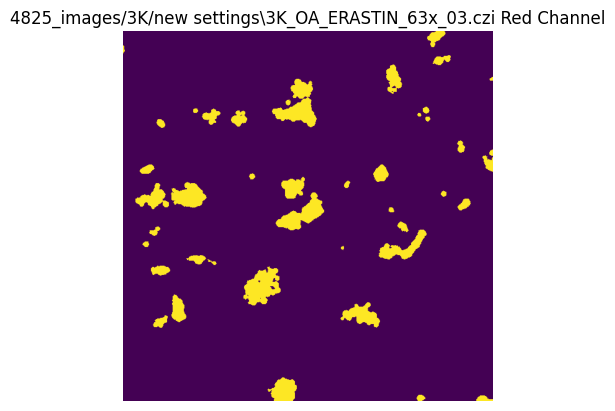

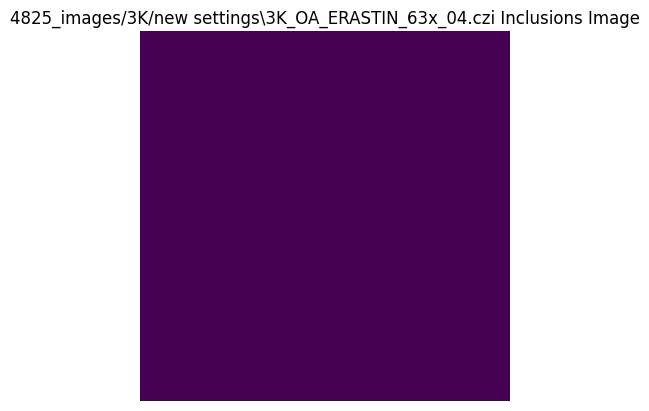

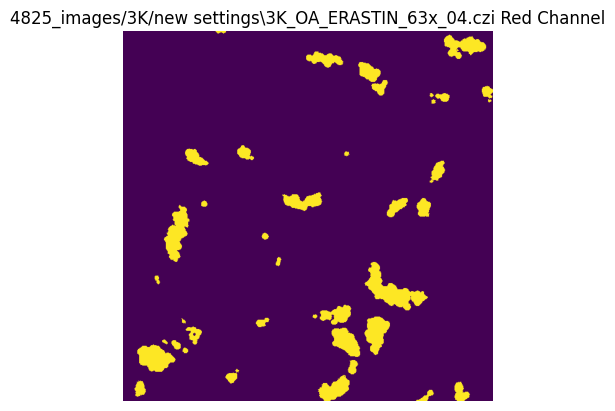

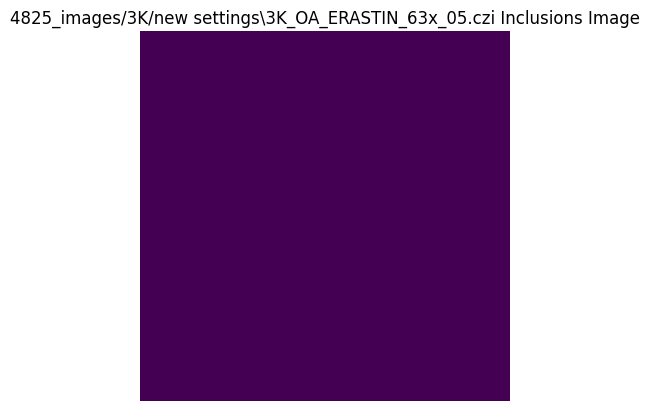

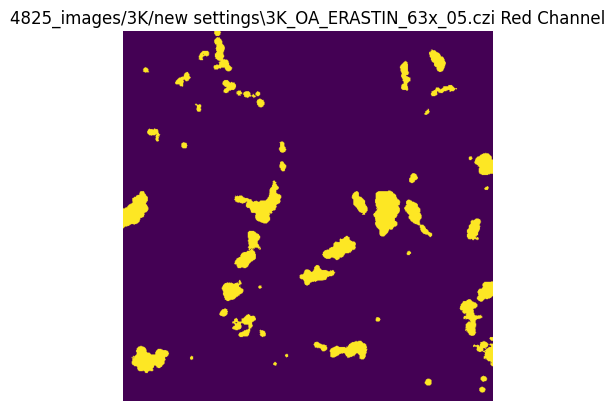

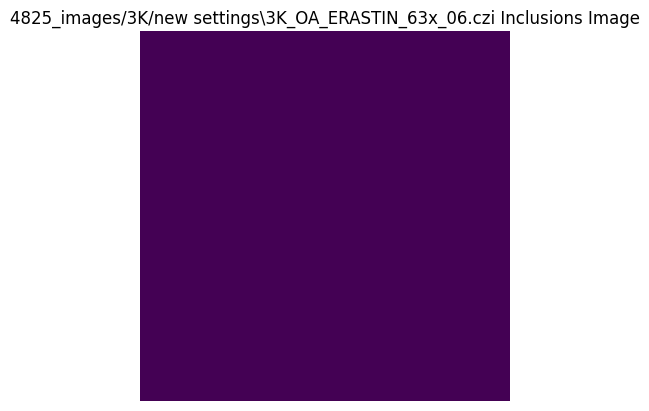

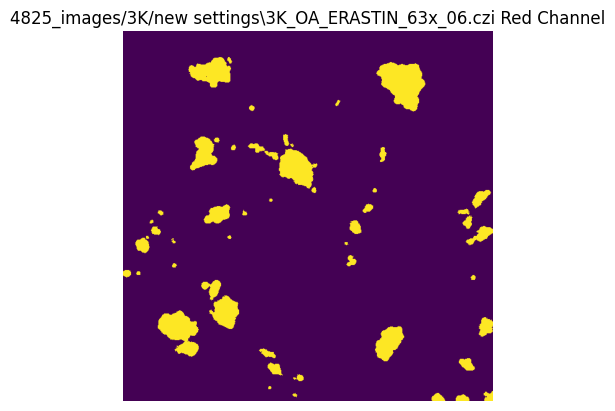

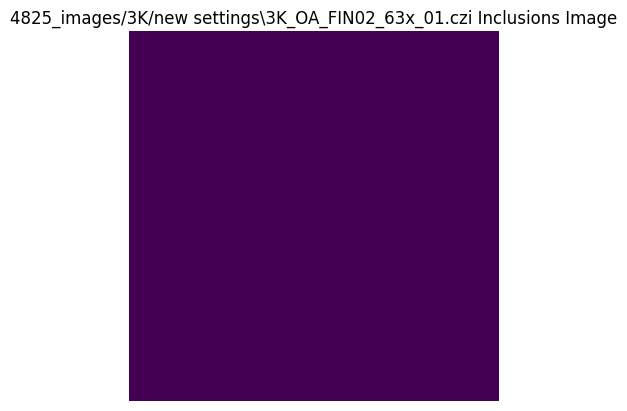

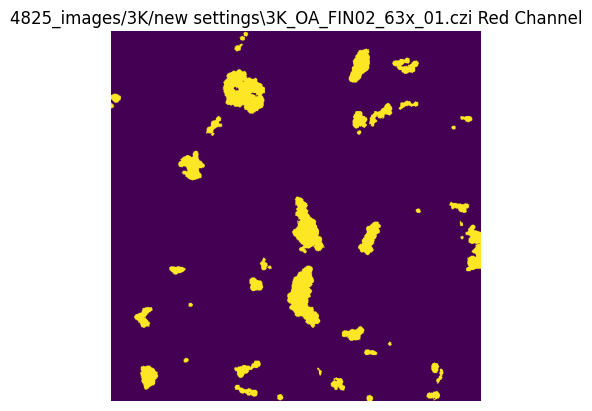

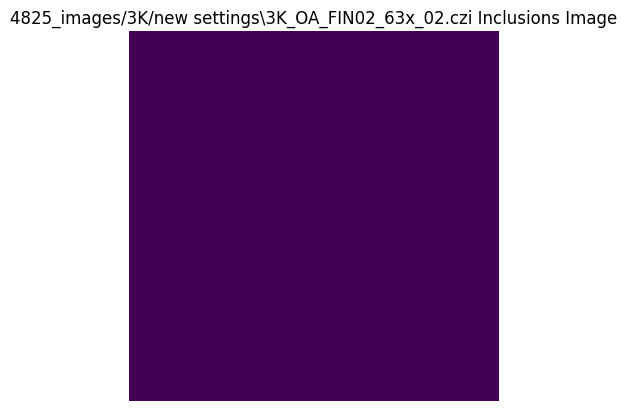

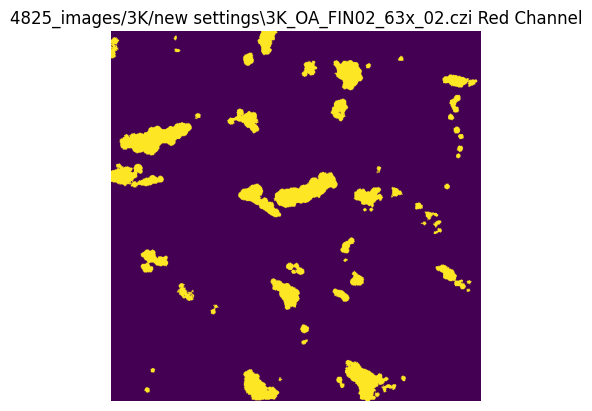

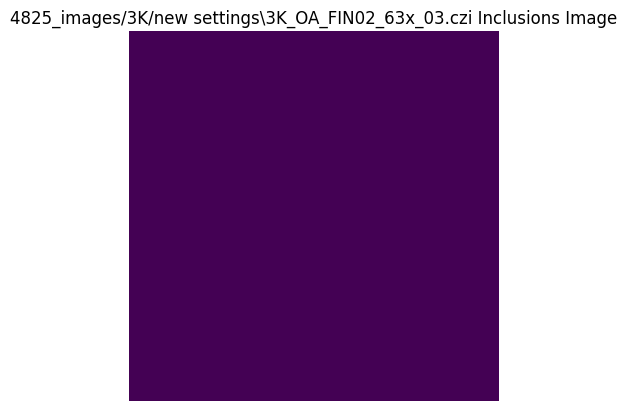

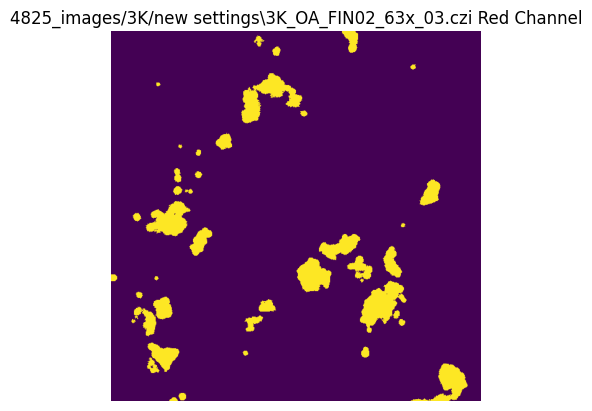

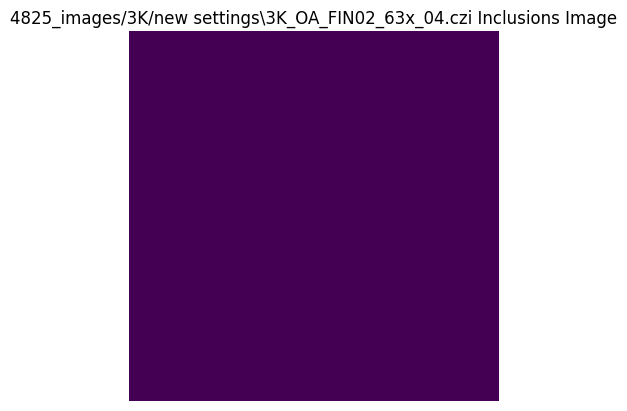

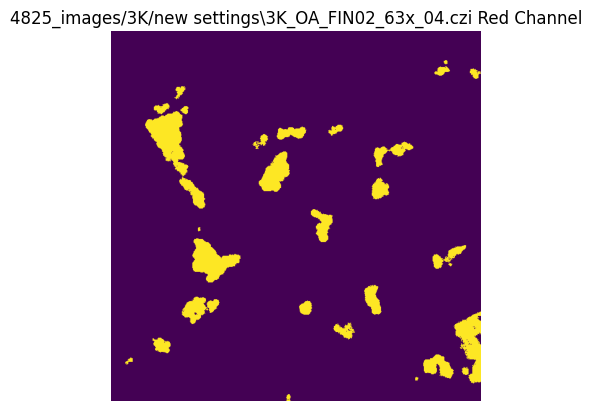

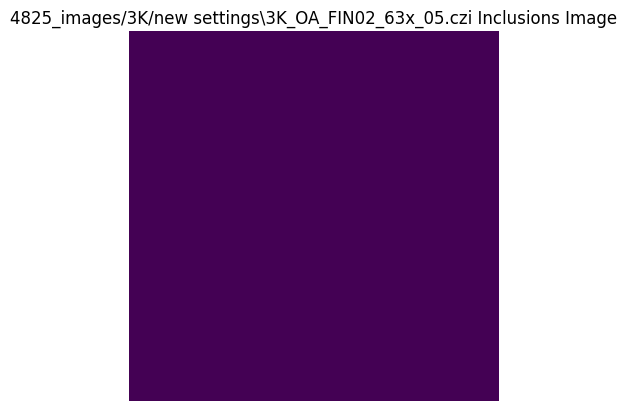

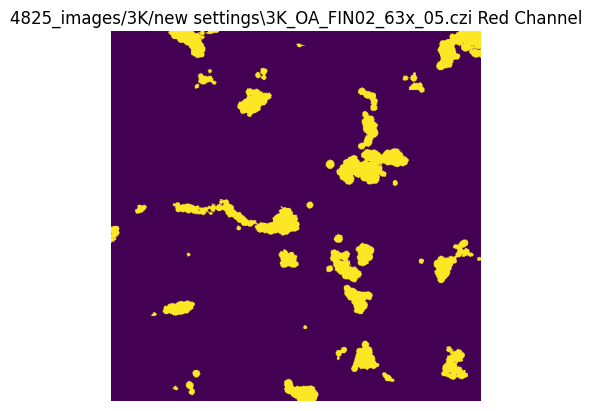

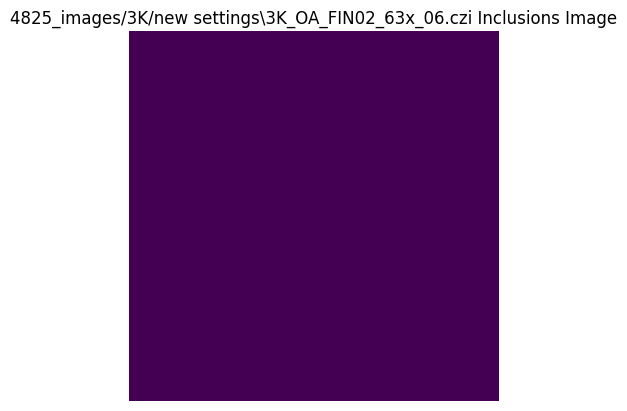

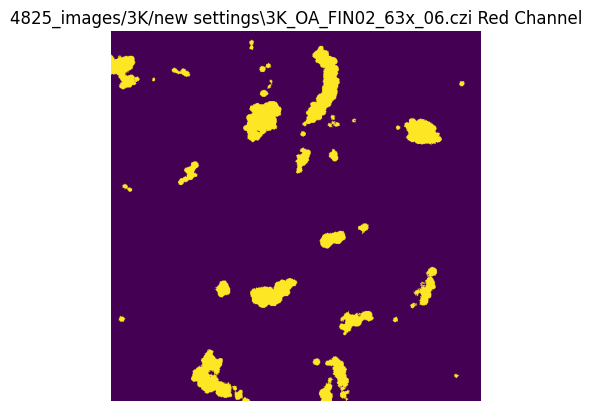

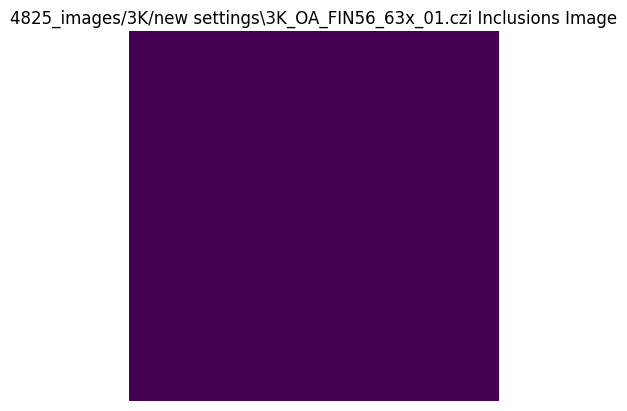

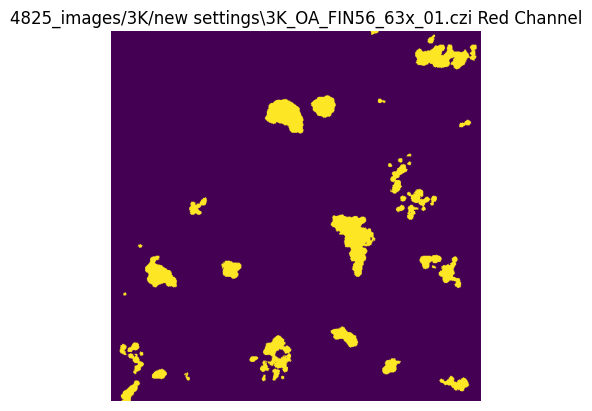

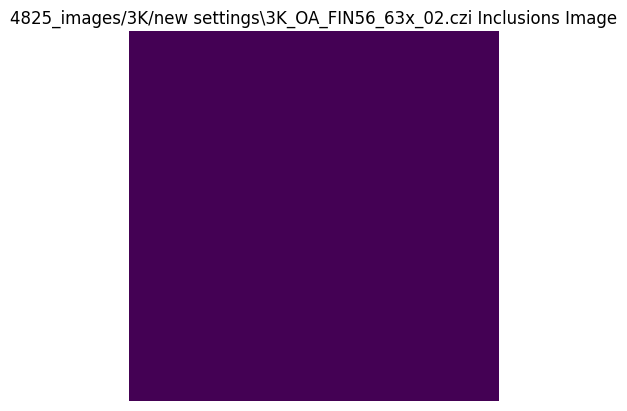

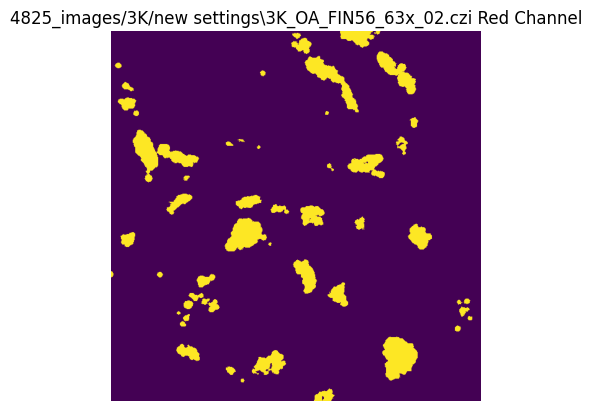

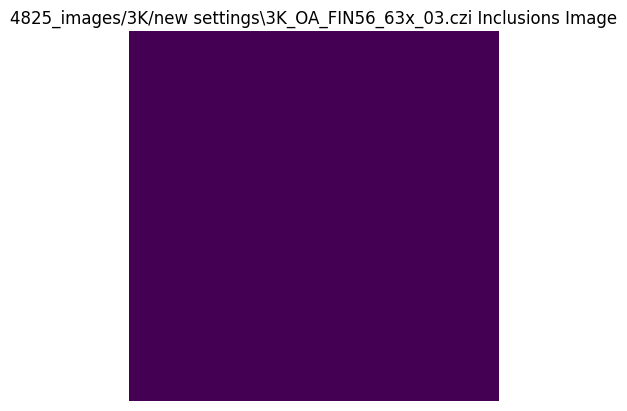

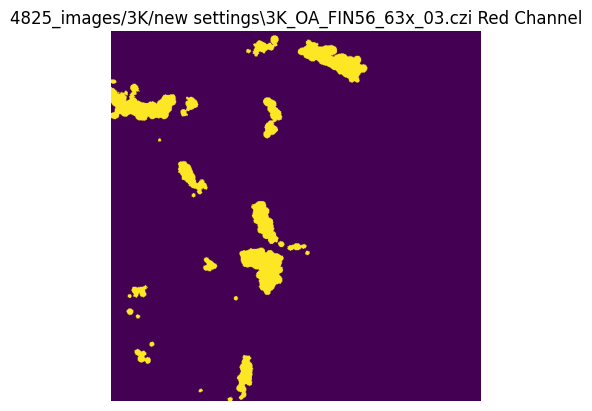

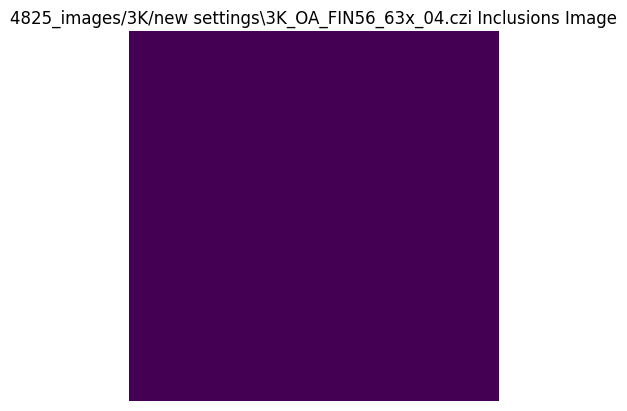

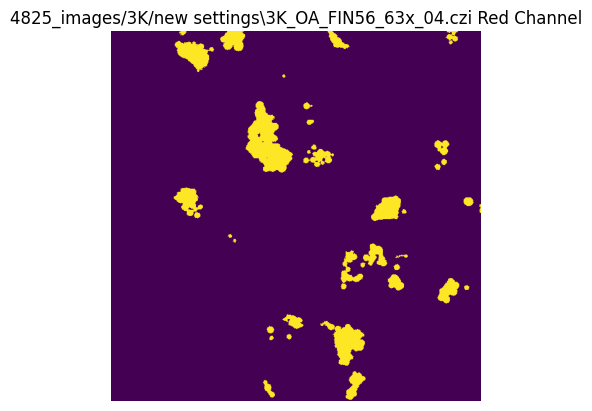

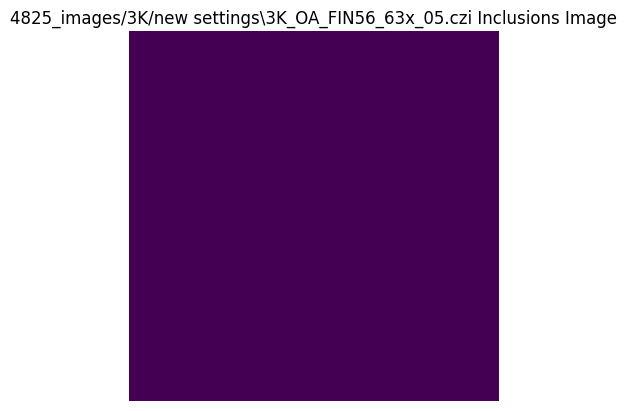

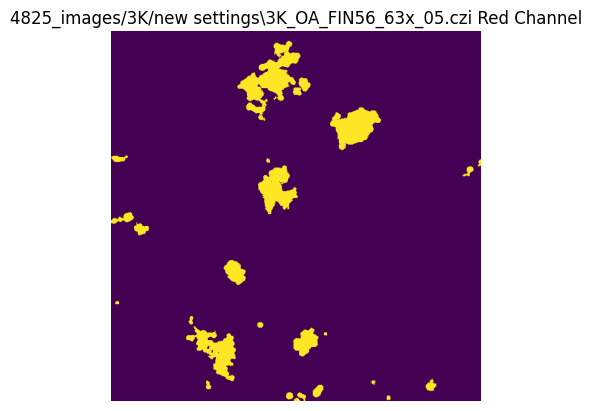

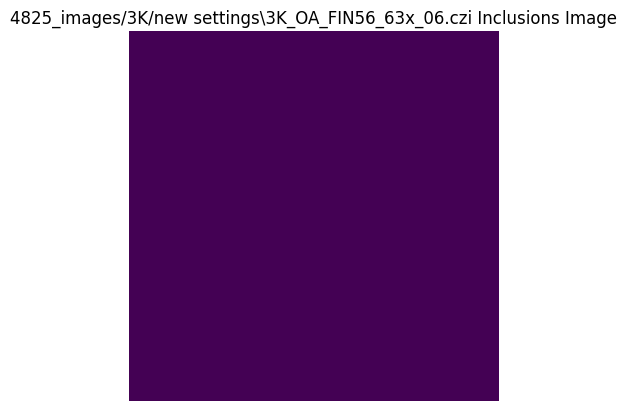

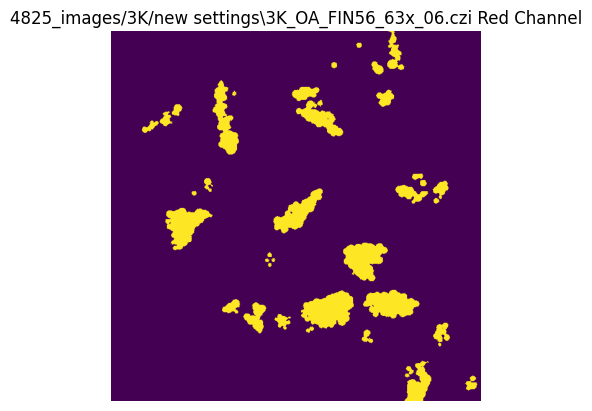

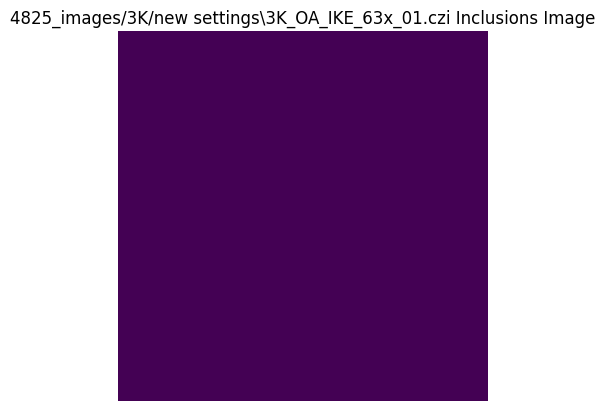

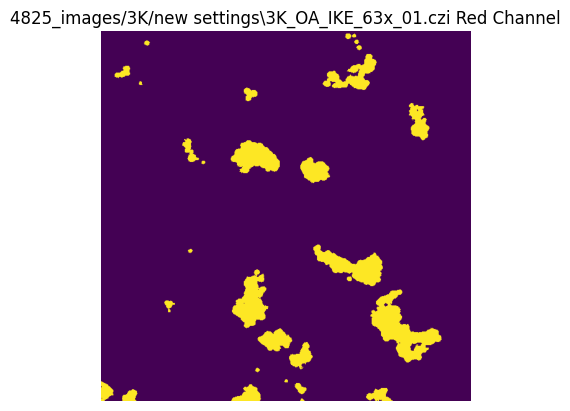

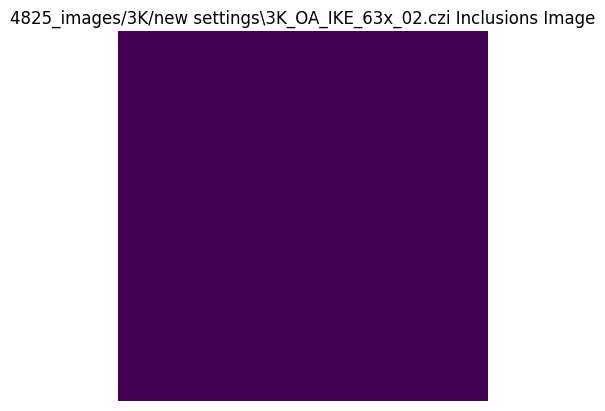

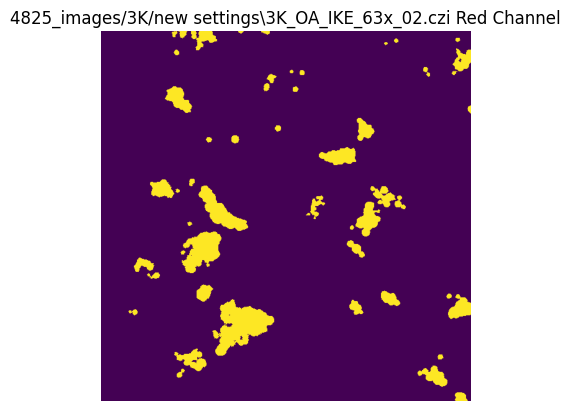

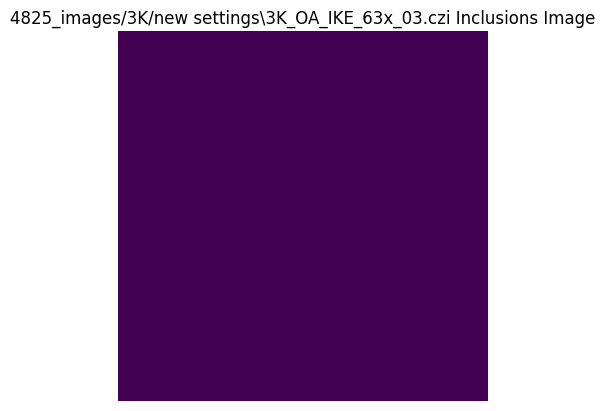

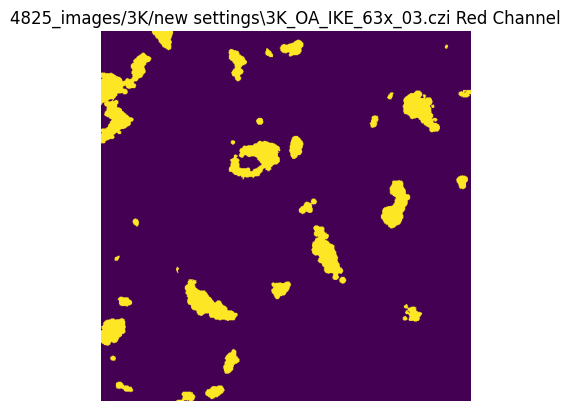

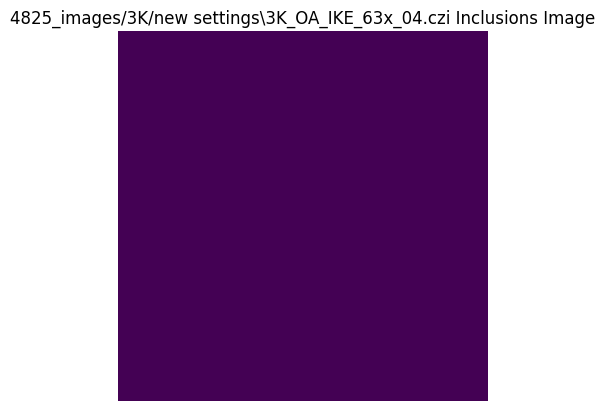

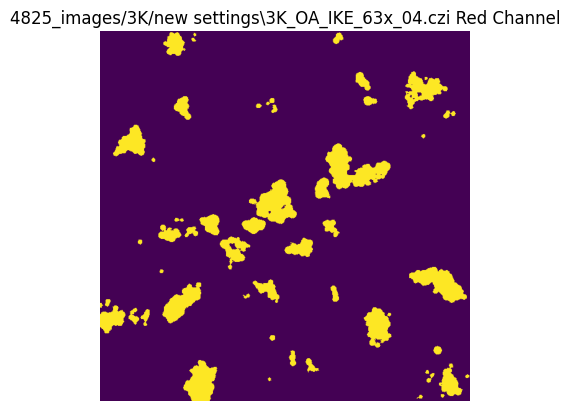

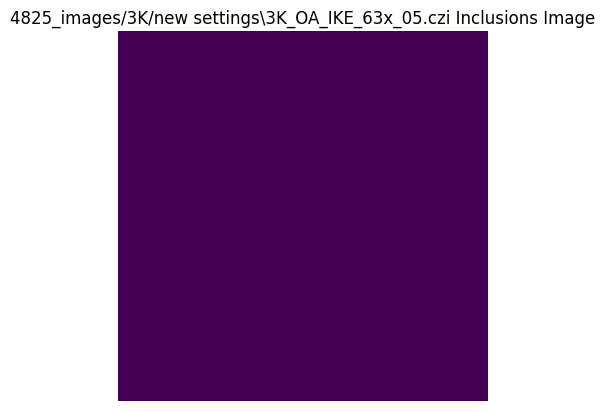

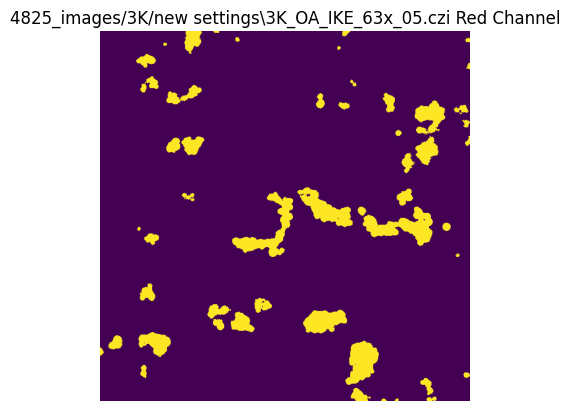

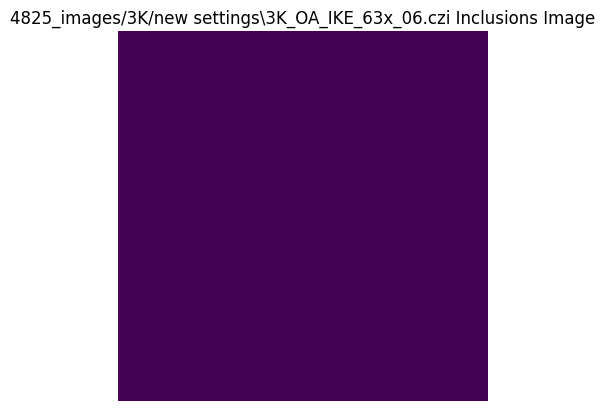

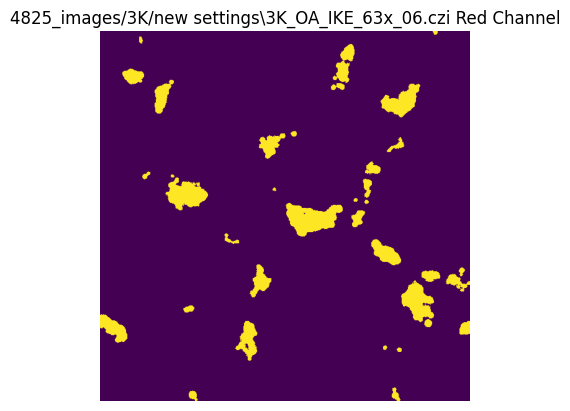

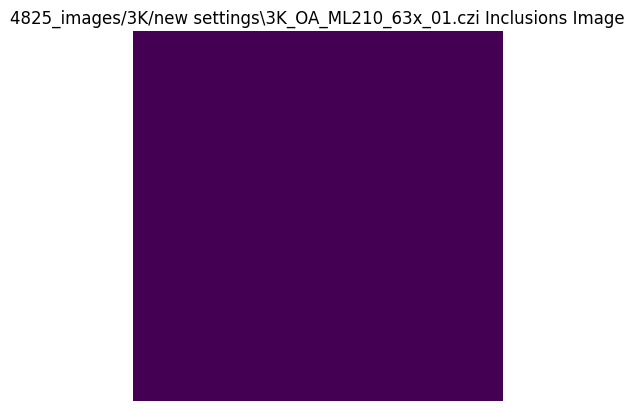

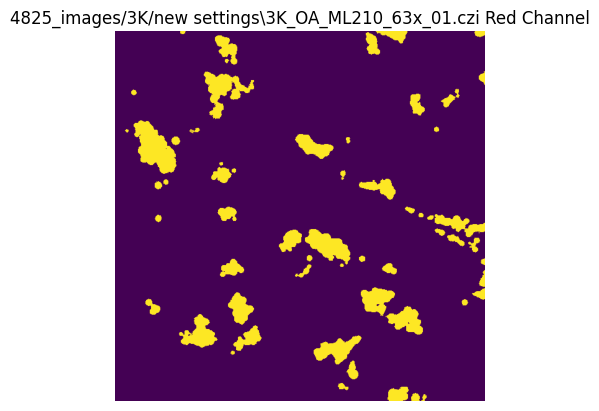

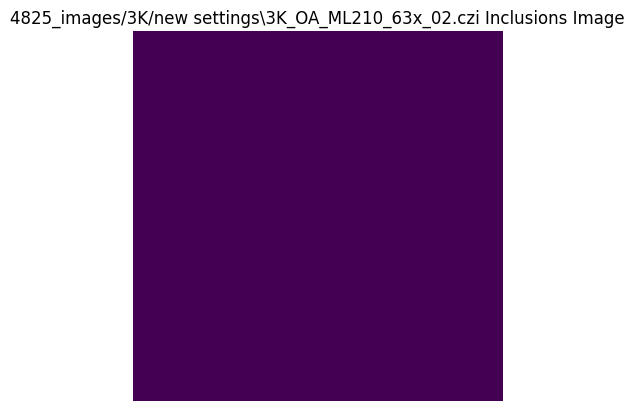

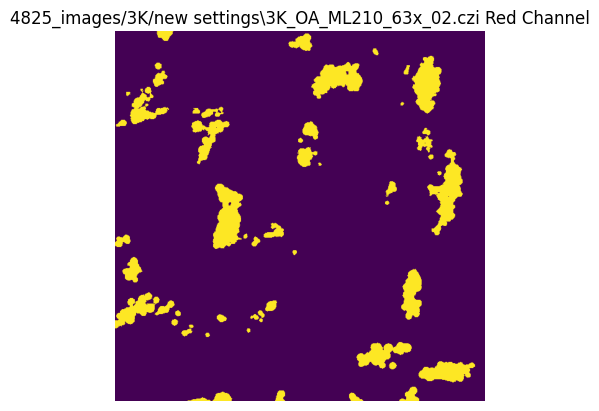

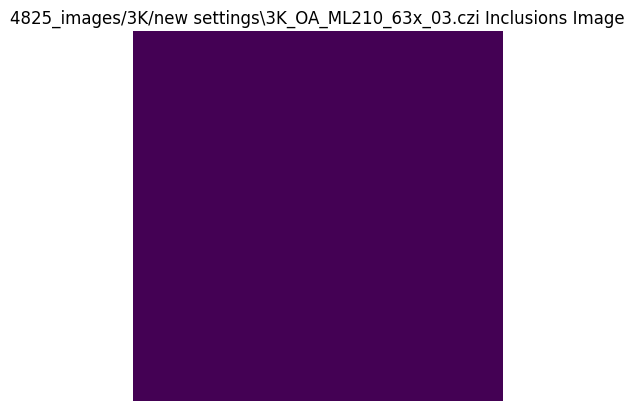

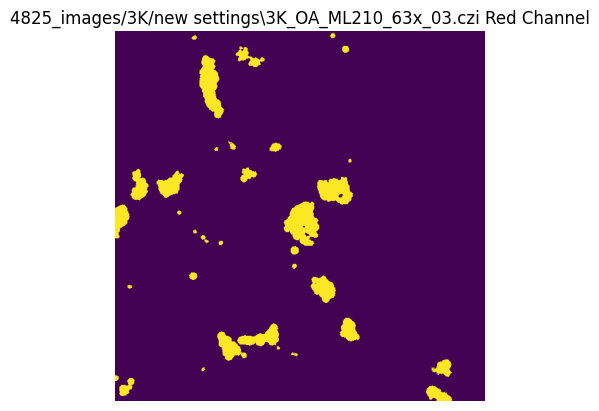

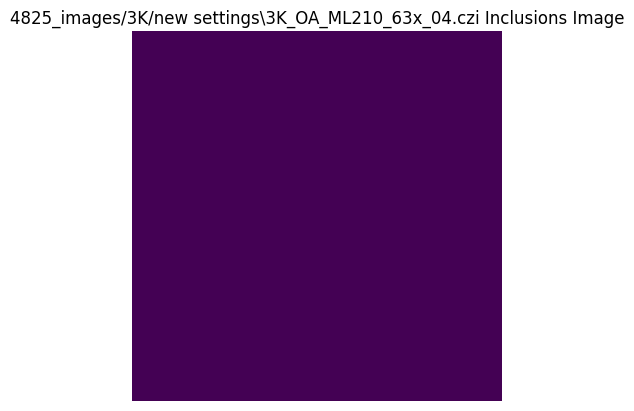

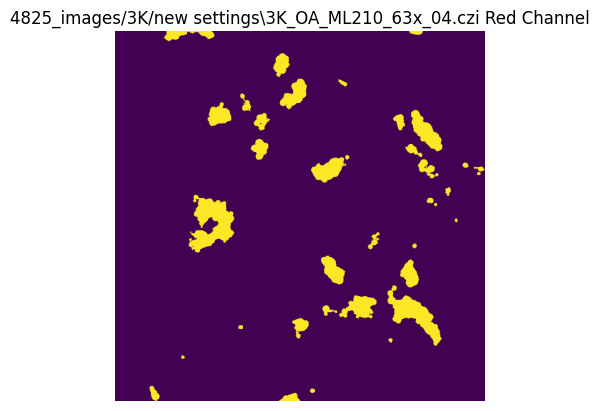

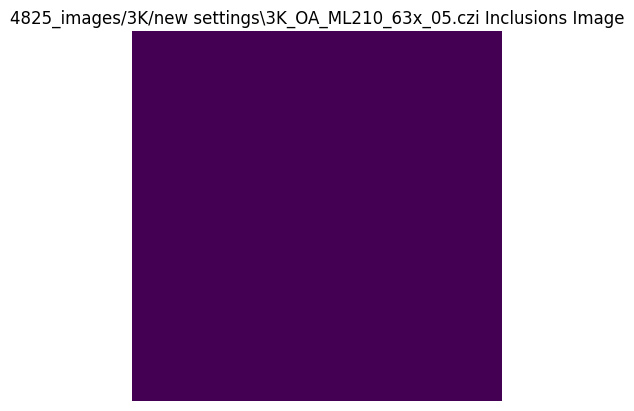

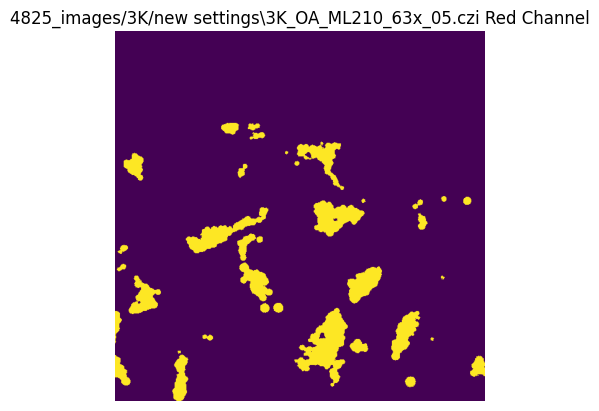

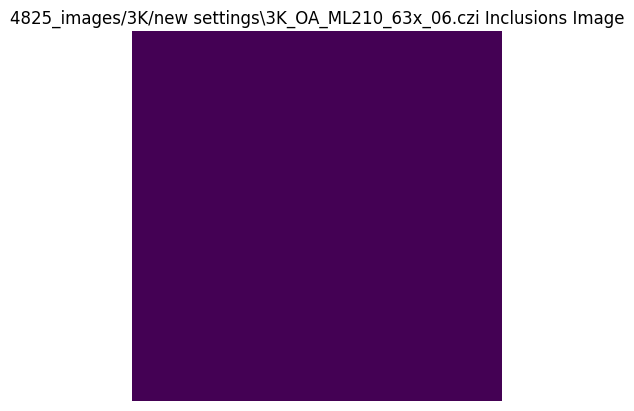

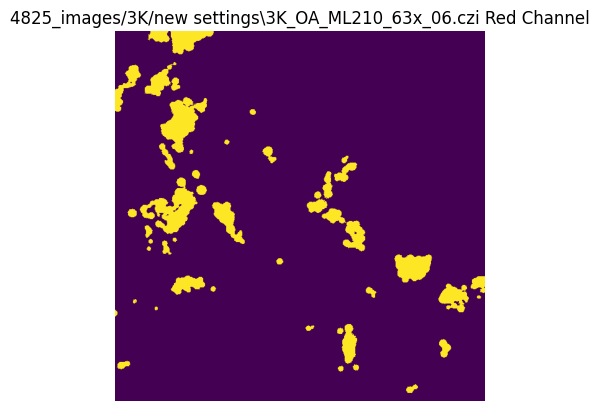

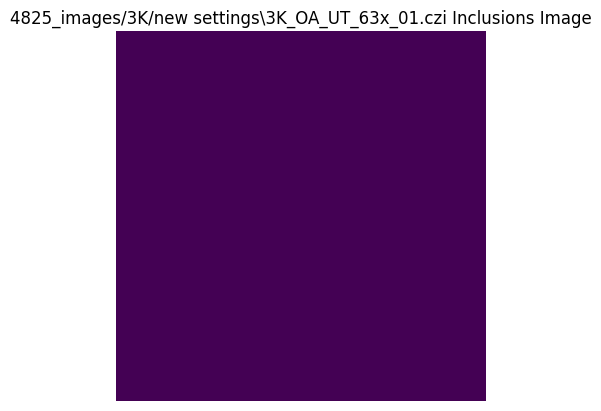

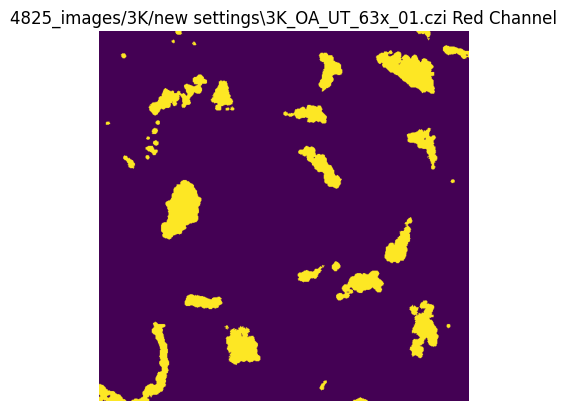

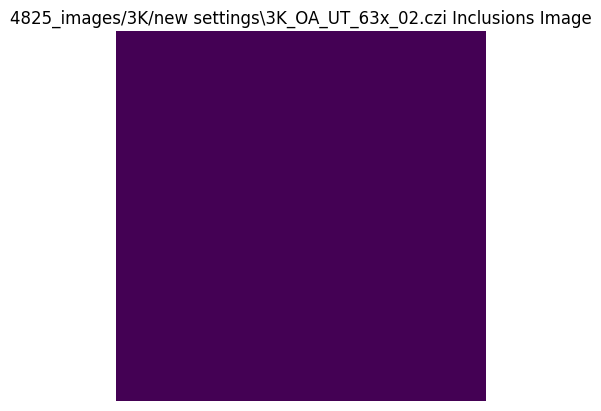

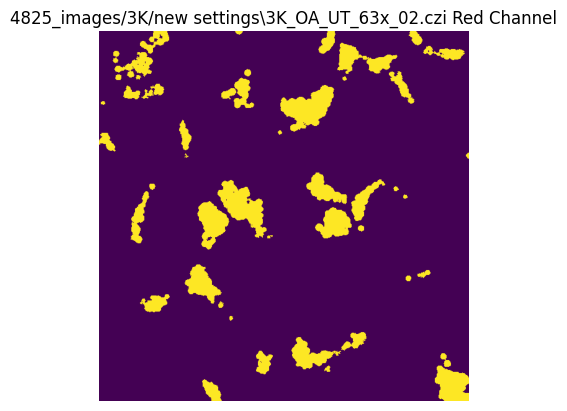

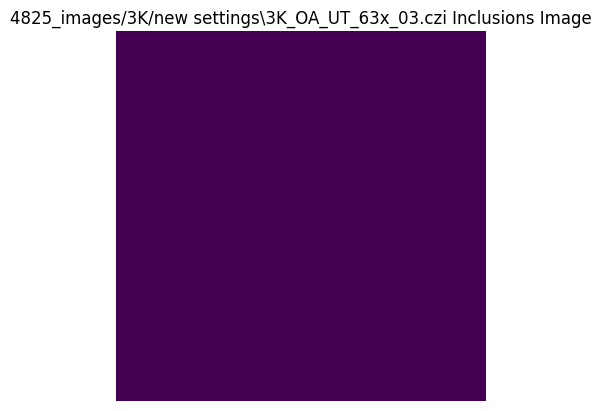

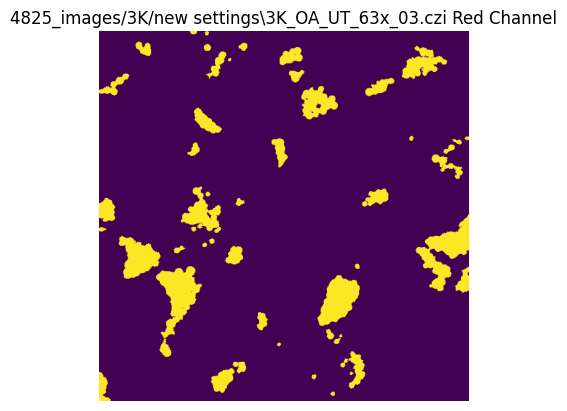

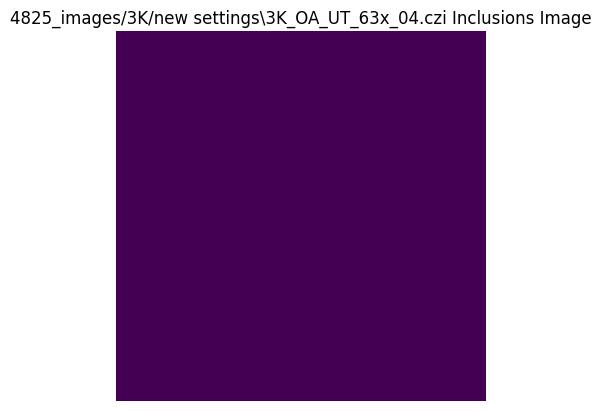

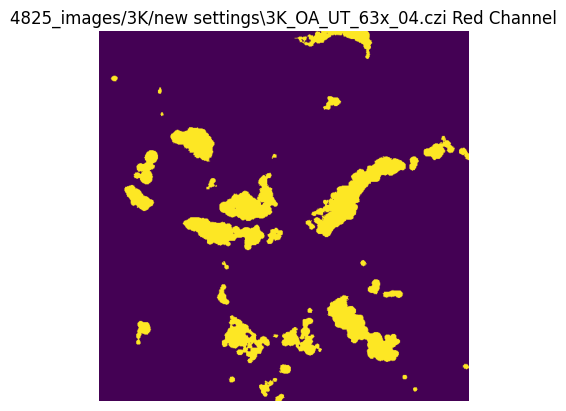

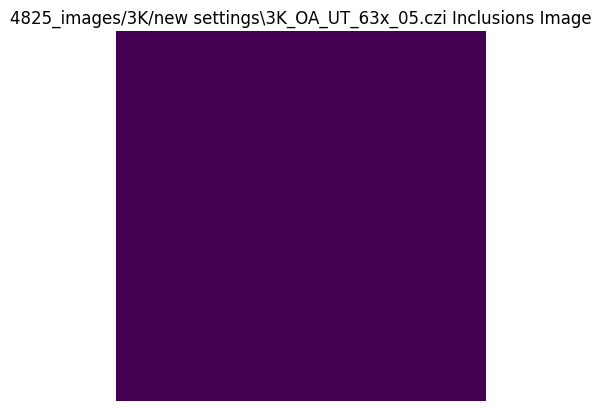

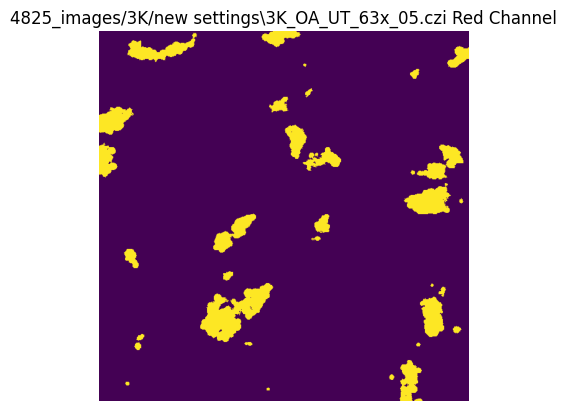

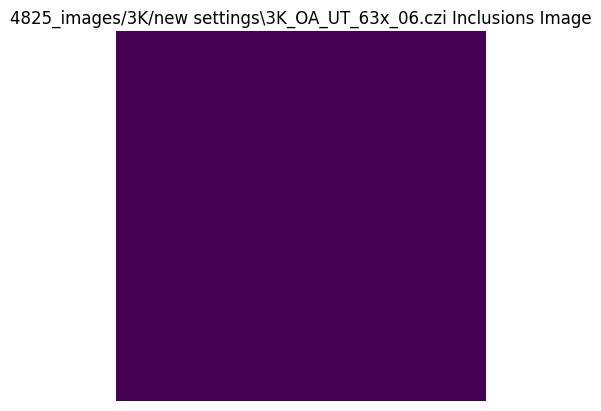

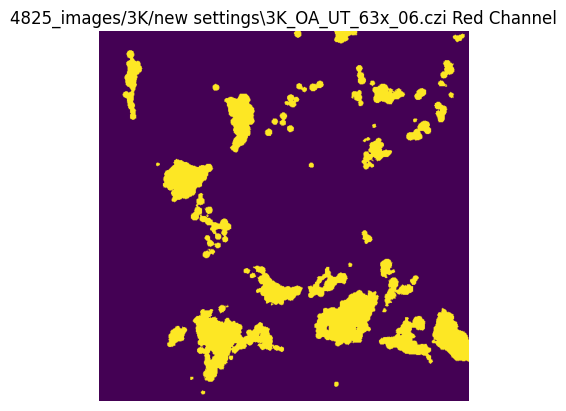

ValueError: All objects passed were None

In [5]:
def main(image_folder):
    images_to_analyze = extract_image_paths(image_folder)
    output_dir = os.getcwd()


    df_summary = []
    
    for path in images_to_analyze:
        image = read_image(path)
        image_squeezed = np.squeeze(image) 

        red, green = extract_channels(image_squeezed)
        df_cell_summary = analysis(red, green, path)
        df_summary.append(df_cell_summary)

    combined_cell_summary_df = pd.concat(df_summary, ignore_index=True)
    output_summary_path = os.path.join(output_dir, '4825_3K.xlsx')
    combined_cell_summary_df.to_excel(output_summary_path, index=False)




if __name__ == "__main__":
    image_folder = '4825_images/3K/new settings'
    main(image_folder)